# Driver Behavior Modelling

From the provided dataset, select at least 2 of the 5 driving maneuvers and determine the sequence of events (atomic actions) that are characteristic of each maneuver. It is essential to analyze and compare the results in a complete and realistic manner. Keep in mind that all files (users) corresponding to the same maneuver should be considered to ensure the events are as representative as possible.

**Error**: Typo in filename `Driver5/STISIMData_3step-Turning` should be `Driver5/STISIMData_3step-Turnings`

---

## Import libraries

In [56]:
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

## Load Sample Dataset

In [57]:
data_path = 'data/'
drivers = list(os.listdir(data_path))
print("Drivers: " ,drivers)

maneuver_types = [f.split("_")[1].split(".")[0] for f in os.listdir(os.path.join(data_path, drivers[0]))]
print("Maneuvers set: ", maneuver_types)

Drivers:  ['Driver1', 'Driver2', 'Driver3', 'Driver4', 'Driver5']
Maneuvers set:  ['3step-Turnings', 'Overtaking', 'Stopping', 'Turnings', 'U-Turnings']


## Load Data of Every Driver
5 drivers available, 4 used and 1 completely isolated for testing purposes

1. Preprocess and create windows for each driver separately
2. Concatenate all drivers data into one dataframe

In [58]:
# Get all drivers data
dfs = {}
for driver in drivers:
    maneuvers = {}
    for maneuver in maneuver_types:
        df_path = os.path.join(data_path, driver, f"STISIMData_{maneuver}.xlsx")
        df = pd.read_excel(df_path)
        maneuvers[maneuver] = df
    dfs[driver] = maneuvers

print(dfs.keys())
print(dfs[drivers[0]].keys())

dict_keys(['Driver1', 'Driver2', 'Driver3', 'Driver4', 'Driver5'])
dict_keys(['3step-Turnings', 'Overtaking', 'Stopping', 'Turnings', 'U-Turnings'])


In [59]:
print(dfs[drivers[0]][maneuver_types[0]].shape)
print(dfs[drivers[0]][maneuver_types[0]].dtypes)
dfs[drivers[0]][maneuver_types[0]].head()

(8933, 23)
Elapsed time            float64
Long Dist               float64
Lat Pos                 float64
Steering wheel angle    float64
Throttle input          float64
Brake pedal force       float64
Gas pedal                 int64
Brake pedal               int64
Clutch pedal              int64
Left turn                 int64
Right turn                int64
Gear                      int64
speed                   float64
RPM                     float64
Hand wheel torque       float64
Maneuver marker flag      int64
Accidents               float64
Collisions              float64
Peds Hit                float64
Speeding Tics           float64
Red Lgt Tics            float64
Speed Exceed            float64
Stop Sign Ticks         float64
dtype: object


,Elapsed time,Long Dist,Lat Pos,Steering wheel angle,Throttle input,Brake pedal force,Gas pedal,Brake pedal,Clutch pedal,Left turn,...,RPM,Hand wheel torque,Maneuver marker flag,Accidents,Collisions,Peds Hit,Speeding Tics,Red Lgt Tics,Speed Exceed,Stop Sign Ticks
0,0.100,0.00,2.17,-8.24,0.0,1.36,0,0,0,0,...,147.244,-0.03,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.152,0.01,2.17,-8.24,0.0,1.36,0,0,0,0,...,184.118,0.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.204,0.01,2.17,-8.24,0.0,1.36,0,0,0,0,...,219.193,0.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.254,0.01,2.17,-8.24,0.0,1.36,0,0,0,0,...,252.554,0.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.304,0.01,2.17,-8.24,0.0,1.36,0,0,0,0,...,284.287,0.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
import copy
# Deep copy of the dataframes

def get_dfs_copy(dfs):
    return copy.deepcopy(dfs)

dfs_copy = copy.deepcopy(dfs)
print(dfs_copy.keys())
print(dfs_copy["Driver1"].keys())

dict_keys(['Driver1', 'Driver2', 'Driver3', 'Driver4', 'Driver5'])
dict_keys(['3step-Turnings', 'Overtaking', 'Stopping', 'Turnings', 'U-Turnings'])


### Preprocessing

#### Feature Selection

In [61]:
# Allowed attributes
attributes = ['speed', 'RPM', 'Steering wheel angle', 'Gas pedal', 'Brake pedal', 'Clutch pedal', 'Gear', 'Maneuver marker flag']
features = ['speed', 'RPM', 'Steering wheel angle', 'Gas pedal', 'Brake pedal', 'Clutch pedal', 'Gear']
target = 'Maneuver marker flag'

# Drop unnecessary columns
for driver in drivers:
    for maneuver in maneuver_types:
        dfs_copy[driver][maneuver] = dfs_copy[driver][maneuver][attributes]

dfs_copy[drivers[0]][maneuver_types[0]].head()

,speed,RPM,Steering wheel angle,Gas pedal,Brake pedal,Clutch pedal,Gear,Maneuver marker flag
0,0.06,147.244,-8.24,0,0,0,0,0
1,0.04,184.118,-8.24,0,0,0,0,0
2,0.02,219.193,-8.24,0,0,0,0,0
3,0.00,252.554,-8.24,0,0,0,0,0
4,0.00,284.287,-8.24,0,0,0,0,0


#### Missing Values

In [62]:
for driver in drivers:
    for maneuver in maneuver_types:
        print(f"Driver: {driver}, Maneuver: {maneuver}")
        # Remove missing values
        dfs_copy[driver][maneuver].dropna(inplace=True)
        print(dfs_copy[driver][maneuver].shape)

Driver: Driver1, Maneuver: 3step-Turnings
(8933, 8)
Driver: Driver1, Maneuver: Overtaking
(5952, 8)
Driver: Driver1, Maneuver: Stopping
(11589, 8)
Driver: Driver1, Maneuver: Turnings
(5308, 8)
Driver: Driver1, Maneuver: U-Turnings
(5801, 8)
Driver: Driver2, Maneuver: 3step-Turnings
(9191, 8)
Driver: Driver2, Maneuver: Overtaking
(6263, 8)
Driver: Driver2, Maneuver: Stopping
(11515, 8)
Driver: Driver2, Maneuver: Turnings
(6315, 8)
Driver: Driver2, Maneuver: U-Turnings
(5206, 8)
Driver: Driver3, Maneuver: 3step-Turnings
(8965, 8)
Driver: Driver3, Maneuver: Overtaking
(7137, 8)
Driver: Driver3, Maneuver: Stopping
(12561, 8)
Driver: Driver3, Maneuver: Turnings
(15139, 8)
Driver: Driver3, Maneuver: U-Turnings
(7087, 8)
Driver: Driver4, Maneuver: 3step-Turnings
(11976, 8)
Driver: Driver4, Maneuver: Overtaking
(6022, 8)
Driver: Driver4, Maneuver: Stopping
(12070, 8)
Driver: Driver4, Maneuver: Turnings
(7658, 8)
Driver: Driver4, Maneuver: U-Turnings
(6437, 8)
Driver: Driver5, Maneuver: 3step-T

In [ ]:
def create_windows(df, window_size, overlap=False):
    """If overlap take the present time row maneuver marker flag
    else take the majority vote of the window.
    """
    df = df.copy()
    new_data = {}

    for attr in attributes:
        for lag in range(window_size):
            new_data[f'{attr}_t-{lag}'] = df[attr].shift(lag)

    if overlap:
        new_data['Maneuver marker flag'] = new_data['Maneuver marker flag_t-0']
    else:
        new_data['Maneuver marker flag'] = (pd.DataFrame.from_dict(new_data)[[f'Maneuver marker flag_t-{i}' for i in range(window_size)]].sum(axis=1) >= window_size/2).astype(int)

    lagged_df = pd.DataFrame(new_data)
    lagged_df = lagged_df.dropna()
    lagged_df.drop(columns=[f'Maneuver marker flag_t-{i}' for i in range(window_size)], inplace=True)

    if not overlap:
        # Select non-overlapping rows
        lagged_df = lagged_df.iloc[::window_size]

    return lagged_df.reset_index(drop=True)

print(df.shape)
df_test = create_windows(df, 5, overlap=True)
df_test.head()
df_test.shape

(5984, 23)


(5980, 36)

#### Windowing

In [73]:
# Create windows for first maneuver of the first driver
window_size = 5

dfs_windowed = create_windows(dfs_copy[drivers[0]][maneuver_types[0]], window_size, overlap=True)
print(dfs_windowed.shape)
dfs_windowed.head()

(8929, 36)


,speed_t-0,speed_t-1,speed_t-2,speed_t-3,speed_t-4,RPM_t-0,RPM_t-1,RPM_t-2,RPM_t-3,RPM_t-4,...,Clutch pedal_t-1,Clutch pedal_t-2,Clutch pedal_t-3,Clutch pedal_t-4,Gear_t-0,Gear_t-1,Gear_t-2,Gear_t-3,Gear_t-4,Maneuver marker flag
0,0.0,0.0,0.02,0.04,0.06,284.287,252.554,219.193,184.118,147.244,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.00,0.02,0.04,314.470,284.287,252.554,219.193,184.118,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.00,0.00,0.02,343.179,314.470,284.287,252.554,219.193,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.00,0.00,0.00,370.486,343.179,314.470,284.287,252.554,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.00,0.00,0.00,396.460,370.486,343.179,314.470,284.287,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0


In [105]:
dfs_copy = get_dfs_copy(dfs)
print(dfs_copy.keys())
for driver in drivers:
    print(driver)
    for maneuver in maneuver_types:
        dfs_windowed = create_windows(dfs_copy[driver][maneuver], window_size, overlap=True)
        dfs_copy[driver][maneuver] = pd.get_dummies(dfs_windowed, columns=[f"Gear_t-{i}" for i in range(window_size)], drop_first=True)

dfs_processed = copy.deepcopy(dfs_copy)
print(dfs_processed.keys(), dfs_processed["Driver1"].keys())

dict_keys(['Driver1', 'Driver2', 'Driver3', 'Driver4', 'Driver5'])
Driver1
Driver2
Driver3
Driver4
Driver5
dict_keys(['Driver1', 'Driver2', 'Driver3', 'Driver4', 'Driver5']) dict_keys(['3step-Turnings', 'Overtaking', 'Stopping', 'Turnings', 'U-Turnings'])


In [85]:
dfs_copy[drivers[0]][maneuver_types[0]].head().T

,0,1,2,3,4
speed_t-0,0.0,0.0,0.0,0.0,0.0
speed_t-1,0.0,0.0,0.0,0.0,0.0
speed_t-2,0.02,0.0,0.0,0.0,0.0
speed_t-3,0.04,0.02,0.0,0.0,0.0
speed_t-4,0.06,0.04,0.02,0.0,0.0
RPM_t-0,284.287,314.47,343.179,370.486,396.46
RPM_t-1,252.554,284.287,314.47,343.179,370.486
RPM_t-2,219.193,252.554,284.287,314.47,343.179
RPM_t-3,184.118,219.193,252.554,284.287,314.47
RPM_t-4,147.244,184.118,219.193,252.554,284.287


---

## Data preprocessing
### Merger Drivers

In [107]:
maneuver_name = "Stopping"

dfs_drivers = []
for  driver in drivers:
    dfs_drivers.append(dfs_processed[driver][maneuver])

driver_5_size = dfs_processed["Driver5"][maneuver_name].shape[0]
dfs_merged = pd.concat(dfs_drivers)
dfs_merged.fillna(False, inplace=True)

dfs_train = dfs_merged.iloc[:-driver_5_size]
dfs_test = dfs_merged.iloc[-driver_5_size:]
print(f"Train drivers: {dfs_train.shape}", f" Test driver: [{dfs_test.shape}]")
dfs_merged.head()

Train drivers: (18948, 61)  Test driver: [(11547, 61)]


C:\Users\maxi.rodriguez\AppData\Local\Temp\ipykernel_38004\433899443.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dfs_merged.fillna(False, inplace=True)


,speed_t-0,speed_t-1,speed_t-2,speed_t-3,speed_t-4,RPM_t-0,RPM_t-1,RPM_t-2,RPM_t-3,RPM_t-4,...,Gear_t-4_1.0,Gear_t-4_2.0,Gear_t-4_3.0,Gear_t-4_4.0,Gear_t-4_5.0,Gear_t-0_6,Gear_t-1_6.0,Gear_t-2_6.0,Gear_t-3_6.0,Gear_t-4_6.0
0,0.0,0.02,0.03,0.06,0.08,259.028,225.999,191.274,154.767,116.385,...,False,False,False,False,False,False,False,False,False,False
1,0.0,0.00,0.02,0.03,0.06,290.445,259.028,225.999,191.274,154.767,...,False,False,False,False,False,False,False,False,False,False
2,0.0,0.00,0.00,0.02,0.03,326.126,290.445,259.028,225.999,191.274,...,False,False,False,False,False,False,False,False,False,False
3,0.0,0.00,0.00,0.00,0.02,354.266,326.126,290.445,259.028,225.999,...,False,False,False,False,False,False,False,False,False,False
4,0.0,0.00,0.00,0.00,0.00,381.032,354.266,326.126,290.445,259.028,...,False,False,False,False,False,False,False,False,False,False


In [110]:
features_lagged = [f for f in dfs_merged if f != "Maneuver marker flag"]
X_train = dfs_train[features_lagged]
y_train = dfs_train["Maneuver marker flag"]

X_test = dfs_test[features_lagged]
y_test = dfs_test["Maneuver marker flag"]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((18948, 60), (11547, 60), (18948,), (11547,))

In [117]:
numerical_features = X_train.select_dtypes(include=['number']).columns
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# Train a Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert predictions to binary values using a threshold
threshold = 0.5
y_pred_binary = np.where(y_pred >= threshold, 1, 0)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
confusion = confusion_matrix(y_test, y_pred_binary)
print(classification_report(y_true=y_test, y_pred=y_pred_binary, target_names=["None", "Stopping"]))
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"Confusion Matrix:\n{confusion}")

              precision    recall  f1-score   support

        None       0.72      0.84      0.77      6437
    Stopping       0.74      0.58      0.65      5110

    accuracy                           0.72     11547
   macro avg       0.73      0.71      0.71     11547
weighted avg       0.73      0.72      0.72     11547

Accuracy: 0.7245171906122803
Precision: 0.7402241594022416
Recall: 0.5816046966731898
F1-Score: 0.6513972602739726
Confusion Matrix:
[[5394 1043]
 [2138 2972]]


C:\Users\maxi.rodriguez\AppData\Local\Temp\ipykernel_38004\988799065.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
C:\Users\maxi.rodriguez\AppData\Local\Temp\ipykernel_38004\988799065.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[numerical_features] = scaler.transform(X_test[numerical_features])


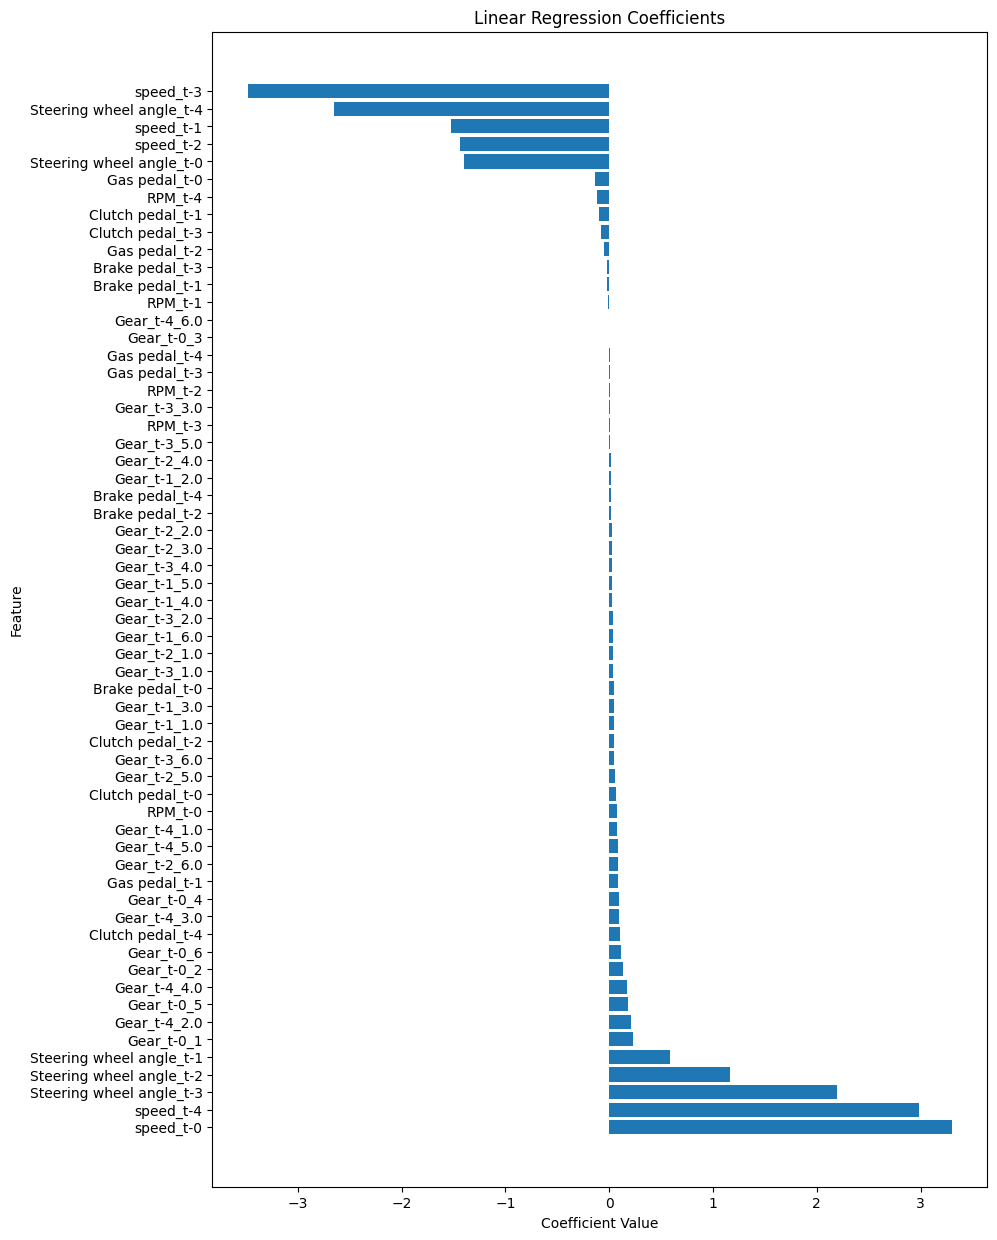

In [119]:
import matplotlib.pyplot as plt

coefficients = model.coef_
feature_names = X_train.columns  # Get feature names

coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coef_df = coef_df.sort_values('Coefficient', ascending=False) # Sort by impact

plt.figure(figsize=(10, 15))
plt.barh(coef_df['Feature'], coef_df['Coefficient'])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Linear Regression Coefficients')
plt.show()

In [113]:
import shap

explainer = shap.KernelExplainer(model.predict, shap.sample(X_train, 10)) #Sample needed
shap_values = explainer.shap_values(X_test) #X_test

shap.summary_plot(shap_values, features=X_test, feature_names=X_test.columns) #X_test

instance_index = 0 # Choose an instance to explain (e.g., the first one)
shap.force_plot(explainer.expected_value, shap_values[instance_index,:], features=X_test.iloc[instance_index,:], feature_names = X_test.columns)

for feature in X_test.columns:
    shap.dependence_plot(feature, shap_values, features=X_test, feature_names = X_test.columns)

  0%|          | 0/11547 [00:00<?, ?it/s]

KeyboardInterrupt: 